<h1 align=center><font size=5>Customer Categorization </h1>
  
* In this practice, I analyze the content of the [E-commerce database](https://www.kaggle.com/carrie1/ecommerce-data) that contains purchases made by about 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09).

* This is a trans-national data set which contains all the transactions for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

* I attempted to segment the customers into several categories, and try to classify new customers into those categories.

# 1) Data preprocessing

## 1.1) Download data

* Download the data set, and read the description [here](https://archive.ics.uci.edu/ml/datasets/Online%20Retail) to understand the features.<br>



In [0]:
# !pip install kaggle
# !mkdir .kaggle

# import json
# token = {"username":"r1n0sh","key":"d6a33ff891d63e8e5c26204db0bd87e5"}

# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

# !chmod 600 /content/.kaggle/kaggle.json
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/content}

In [1]:
from google.colab import drive
drive.mount('/content/mydriv')
path = '/content/mydriv/My Drive/Customer_Segmentation/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/mydriv


## 1.2) Import libraries

* Importing all the python libraries used in this project



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime, nltk, warnings
# import matplotlib.cm as cm
# import itertools
# from pathlib import Path
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score
# from sklearn import preprocessing, model_selection, metrics, feature_selection
# from sklearn.model_selection import GridSearchCV, learning_curve
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix
# from sklearn import neighbors, linear_model, svm, tree, ensemble
# from wordcloud import WordCloud, STOPWORDS
# from sklearn.ensemble import AdaBoostClassifier
# from IPython.display import display, HTML
# import plotly.graph_objs as go
warnings.filterwarnings("ignore")
%matplotlib inline


## 1.3)  Read data + timestamp

* Read the data into a pandas dataframe `df`, investigate shape and head. Using `pd.to_datetime` to transform the timestamps features to right format

In [4]:
# Read the data into a pandas dataframe `df`
df = pd.read_csv(path+'data.csv',encoding='latin', dtype={'CustomerID': str})

# timestamp
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### Raw Data
* Number of columns (features) = **8**
* Number of rows (records or observations) = **541909**

## 1.4) Missing values

* Finding the percentage of missing values for each feature. 
* Create a new dataframe `df_dropna` by removing observations without CustomerID. 

In [5]:
# observations containing NaN
df.loc[df.isnull().sum(axis=1) > 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [6]:
# missing percentages
df.isnull().sum(axis=0)*100 / df.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [14]:
# if we drop all entries with unknown customer ID, missing values in Description also disappear
df_dropna = df.dropna(axis = 0, subset = ['CustomerID', 'Description'])

# missing percentages
df_dropna.isnull().sum(axis=0) / df_dropna.shape[0]

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [8]:
df_dropna.shape

(406829, 8)

### Raw Data after dropping missing values
* Number of columns (features) = **8**
* Number of rows (records or observations) = **406829**

## 1.5) Duplicates

* Checking for any duplicate records in the data i.e. 2 identical observations. If exists, remove the duplicates (keep one for each distinct obervation of course) and save to `df_dropna`.

In [15]:
print("Initial number of duplicates is ", sum(df_dropna.duplicated()))

Initial number of duplicates is  5225


In [17]:
# Dropping all duplicates
df_dropna.drop_duplicates(inplace=True)
# check - should be zero if you done everything right
print("number of duplicates after dropping is ", sum(df_dropna.duplicated()))

number of duplicates after dropping is  0


In [18]:
df_dropna.shape

(401604, 8)

### Raw Data after dropping missing values
* Number of columns (features) = **8**
* Number of rows (records or observations) = **401604**

## 1.6) Save data
Save preprocessed data to the file `data_dropna.csv` and the original data to `data.csv`

In [0]:
df_dropna.to_csv(path + 'data_dropna.csv')
df.to_csv(path + 'data_orig.csv') 


# 2) Data Exploration
This dataframe contains 8 variables that correspond to:

1. **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
4. **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
5. **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
6. **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
7. **Country**: Country name. Nominal, the name of the country where each customer resides.

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')
path = '/content/mydriv/My Drive/Customer_Segmentation/'
df_dropna = pd.read_csv(path + 'data_dropna.csv', encoding='latin', dtype={'CustomerID': str}) 
df = pd.read_csv(path + 'data.csv', encoding='latin', dtype={'CustomerID': str}) 
df_dropna.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## 2.1) Number of customers ( with reference to products and countries)

* Find the numbers of customers, products and transactions (let's say each transaction corresponds to a unique InvoiceNo).

* Find top 10 countries with the largest numbers of purchases sorted in descreasing order.  Use `.groupby` and `.unique` functions.

In [25]:
df_dropna[['InvoiceNo', 'StockCode', 'CustomerID',]].describe()

,InvoiceNo,StockCode,CustomerID
count,401604,401604,401604
unique,22190,3684,4372
top,576339,85123A,17841
freq,542,2065,7812


* As we can see below on the row "unique", there are **22190** *transactions*, **3684** *products* and **4372** *customers*.

In [31]:
df_dropna[['Country', 'InvoiceNo']].groupby('Country').count()\
.sort_values(by='InvoiceNo', ascending=False).head(10)

,InvoiceNo
Country,
United Kingdom,356728
Germany,9480
France,8475
EIRE,7475
Spain,2528
Netherlands,2371
Belgium,2069
Switzerland,1877
Portugal,1471


## 2.2) Products per transaction

* Finding the numbers of products in each transaction, then print the top 10 

In [32]:
# number of products per transaction
df_dropna[['InvoiceNo','StockCode']].groupby(['InvoiceNo']).count()\
.rename(columns = {'StockCode':'Number of products'})\
.sort_values(by='Number of products', ascending=False).head(10)

,Number of products
InvoiceNo,
576339,542
579196,533
580727,529
578270,442
573576,435
567656,421
567183,392
575607,377
571441,364


## 2.3) Transactions per country

Below we find the numbers of transactions per country:

In [26]:
# transactions per country
transPerCountry = df[['InvoiceNo', 'Country']].groupby(['InvoiceNo', 'Country'])\
.count().reset_index(drop = False)\
['Country'].value_counts()
print(transPerCountry)

United Kingdom          23494
Germany                   603
France                    461
EIRE                      360
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                74
Portugal                   71
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Hong Kong                  15
Unspecified                13
Malta                      10
Singapore                  10
Israel                      9
USA                         7
Iceland                     7
Canada                      6
Greece                      6
Czech Republic              5
European Community          5
Bahrain                     4
Lithuania                   4
United Ara

In [28]:
# choropleth map
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

data = dict(type='choropleth',
locations = transPerCountry.index,
locationmode = 'country names', z = transPerCountry,
text = transPerCountry.index, colorbar = {'title':'Number of Orders'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of transactions per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## 2.4) Cancelled orders

Among observations, there are those with negative quantities. They correspond to cancelled orders (transactions).

* Computing the number of cancelled transactions (cancelled transactions' InvoiceNo contain letter 'C')

In [31]:
orders = df_dropna.InvoiceNo.unique()
n_orders = orders.shape[0]
# check for character 'C' in InvoiceNo
n_cancelled_orders = pd.Series(orders).apply(lambda x: 'C' in x).sum()

print('Number of cancelled transactions: {}/{} ({:0.2f}%)'.format(n_cancelled_orders, n_orders,\
n_cancelled_orders/n_orders*100))

Number of cancelled transactions: 3654/22190 (16.47%)


#### Orders were majorly get cancelled due to 2 main reasons:

1. Customer wish due to defective piece etc.
2. Discounts after purchase

In [32]:
df.loc[df.InvoiceNo.apply(lambda x: 'C' in x)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


* When there is a cancelling order, it's often the case that counterpart which is a another purchase order with the same CustomerID, Description and UnitPrice, but different InvoiceID and date.

* Cancellations without a counterpart problaly due to the fact that the purchase commands happen before the beginning date of the data set, or they are discounts.

* A new variable `QtyCancel` in the dataframe that indicate if part of the order has been canceled. 

* Two cases needs to be verified:

1. a cancel order exists without counterpart (`bad_entry`)
2. there's at least one counterpart (`delete_entry`)

* The index of the corresponding cancel orders are respectively kept in the `bad_entry` and `delete_entry` lists.

In [0]:
# Note: we don't consider discount entries
# bad_entry: cancel entries with no counterpart
# delete_entry: cancel entries with counterparts and there is at least one entry with higher quantity!

### Takes a while to run as iterrows() is large

df_cleaned = df_dropna.copy(deep = True)
df_cleaned['QtyCancel'] = 0

delete_entry = [] ; bad_entry = []

for index, col in  df_dropna.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_dropna[(df_dropna['CustomerID'] == col['CustomerID']) &
                         (df_dropna['StockCode']  == col['StockCode']) & 
                         (df_dropna['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_dropna['Quantity']   > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        bad_entry.append(index)
    
    # Cancelation WITH only one counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QtyCancel'] = -col['Quantity']
        delete_entry.append(index)        
    
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0, ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QtyCancel'] = -col['Quantity']
            delete_entry.append(index) 
            break   

In [34]:
print(len(delete_entry), len(bad_entry))

7521 1226


In [35]:
df_cleaned.drop(delete_entry, axis = 0, inplace = True)
df_cleaned.drop(bad_entry, axis = 0, inplace = True)
df_cleaned.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCancel
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [36]:
df_cleaned.shape

(392857, 10)

### Data after dropping cancelled entries
* Number of columns (features) = **9**
* Number of rows (records or observations) = **392857**

## 2.6) Aggregate Prices

* Creating a variable `TotalPrice` for the dataframe, which is the total price for each line by using `UnitPrice`, `Quantity` and `QtyCancel` features for this

In [37]:
# Total price for each row
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QtyCancel'])
df_cleaned.sort_values('CustomerID')[:5]

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCancel,TotalPrice
37511,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
100693,148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
318798,428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
318797,428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
318796,428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


* Each entry of the dataframe indicates prizes for a single kind of product, so an order is split on several lines. We collect all the commands during a single order (same InvoiceNo) to recover the total order prize. 

* Saving result in a dataframe `Aggregate_Price`. It consists of features: `CustomerID`, `InvoiceNo`, `agg_price` and `InvoiceDate`

In [38]:
# sum the commands for each order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
Aggregate_Price = temp.rename(columns = {'TotalPrice':'agg_price'})

# command date
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
Aggregate_Price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# keep only positive purchases
Aggregate_Price = Aggregate_Price[Aggregate_Price['agg_price'] > 0]
Aggregate_Price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,agg_price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


Purchases can be divided according to total prizes, run the code:

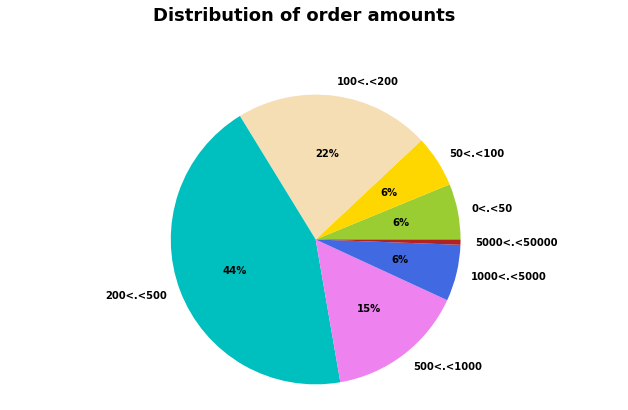

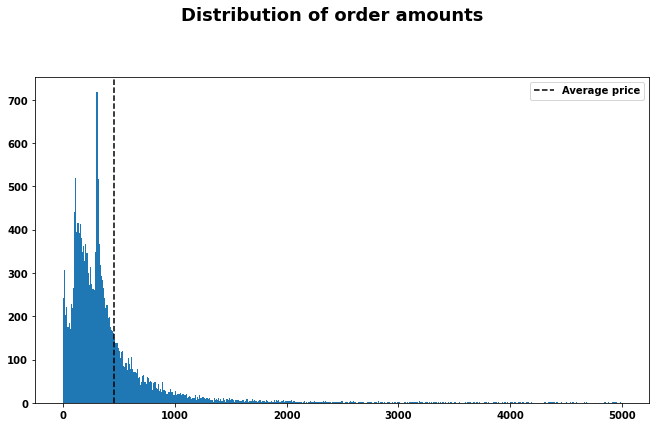

In [39]:
import matplotlib.pyplot as plt

# Define price ranges
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = Aggregate_Price[(Aggregate_Price['agg_price'] < price) &
                       (Aggregate_Price['agg_price'] > price_range[i-1])]['agg_price'].count()
    count_price.append(val)

# Distribution of order amounts    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

# Distribution of order amounts    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
ax.hist(Aggregate_Price['agg_price'][Aggregate_Price['agg_price']<5000].values, bins=500)
ax.axvline(x=Aggregate_Price['agg_price'].mean(), color='k', linestyle='--', label='Average price')
ax.legend()
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

In [40]:
Aggregate_Price['agg_price'].mean()

456.3380945754987

* The average cost per one invoice is **456.34 GBP**

## 2.7) Save data
Save preprocessed data to the file `data_cleaned.csv` and `basket_price.csv`

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
path = '/content/mydriv/My Drive/Customer_Segmentation/'
df_cleaned.to_csv(path + 'data_cleaned.csv')
Aggregate_Price.to_csv(path + 'Aggregate_Price.csv')

# 3) Product categories

* Products are uniquely identified through the `StockCode` variable. A shrort description of the products is given in the `Description` variable.

* In this section, I used the content of the variable `Description` to group the products into different categories.

* I extracted keywords from `Description` with the function below.

In [41]:
# import pandas as pd

# from google.colab import drive
# drive.mount('/content/drive')
# relative_path = '/content/drive/My Drive/Datasets/Customer_segmentation/'

df_dropna = pd.read_csv(path + 'data_dropna.csv', encoding='latin', dtype={'CustomerID': str}) 
df_cleaned = pd.read_csv(path + 'data_cleaned.csv', encoding='latin', dtype={'CustomerID': str}) 

df_dropna.drop(['Unnamed: 0'], axis=1, inplace=True)
df_cleaned.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,  inplace=True)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCancel,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


*  Defined a function `keywords_inventory` to extract keywords from (unique) Descriptions
* This function takes the dataframe and analyzes the content of the `Description` column by performing the following operations:

1. extract the names (proper, common) appearing in the products description
2. for each name, extract the root of the word and aggregate the set of names associated with this particular root
3. count the number of times each root appears in the dataframe
4. when several words are listed for the same root, we consider that the keyword associated with this root is the shortest one (this systematically selects the singular when there are singular/plural variants)

In [50]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, col_des = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[col_des]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(col_des,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 3.1) Unique descriptions
* Extract unique descriptions using `keywords_inventory` function

In [51]:
df_products = pd.DataFrame(df_dropna['Description'].unique()).rename(columns = {0:'Description'})
print("number of different descriptions is:", len(df_products))
# Using the function
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)
print(keywords,'\n', keywords_roots,'\n',  keywords_select,'\n',  count_keywords)

number of different descriptions is: 3896
Nb of keywords in variable 'Description': 1483
['heart', 'holder', 'metal', 'lantern', 'cream', 'cupid', 'coat', 'hanger', 'union', 'flag', 'water', 'bottle', 'nest', 'box', 'glass', 'star', 'hand', 'jack', 'warmer', 'dot', 'bird', 'ornament', 'poppy', 'playhouse', 'bedroom', 'kitchen', 'feltcraft', 'princess', 'charlotte', 'doll', 'ivory', 'cosy', 'colour', 'teaspoons', 'vintage', 'jigsaw', 'block', 'alphabet', 'home', 'building', 'word', 'love', 'recipe', 'england', 'jam', 'jar', 'rack', 'paris', 'fashion', 'bath', 'alarm', 'clock', 'bakelike', 'pink', 'green', 'panda', 'bunny', 'sheet', 'tape', 'globe', 'head', 'tail', 'game', 'set/2', 'retrospot', 'tea', 'towel', 'round', 'snack', 'woodland', 'spaceboy', 'lunch', 'i', 'london', 'circus', 'bag', 'design', 'toadstool', 'night', 'light', 'seaside', 'puzzles', 'mini', 'parade', 'paint', 'postage', 'paper', 'chain', 'christmas', 'parasol', 'coffee', 'mug', 'planet', 'billboard', 'love/hate', 'wo

The function returns three variables:
* `keywords`: the list of extracted keywords
* `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
* `count_keywords`: dictionary listing the number of times each word is used


## 3.2) Dictionary to list
* Convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences, showing the 5 most common

In [52]:
# turn the dict into a list and sort by no of occurrences
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)
list_products[:5]


[['heart', 267], ['vintage', 211], ['set', 206], ['pink', 189], ['bag', 165]]

## 3.3) Plot the words
* Plotting the top 25 words with occurences (in the unique descriptions!)

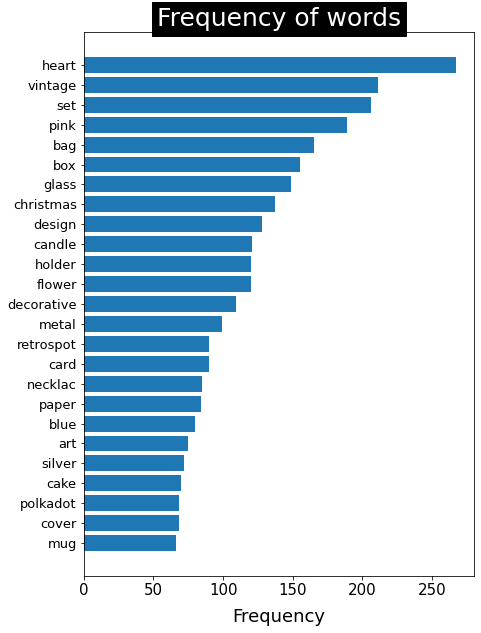

In [53]:
import matplotlib.pyplot as plt

list_prod = list_products
N_words = 25

#
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 10))
y_axis = [i[1] for i in list_prod[:N_words]]
x_axis = [k for k,i in enumerate(list_prod[:N_words])]
x_label = [i[0] for i in list_prod[:N_words]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Frequency", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()


#
plt.title("Frequency of words",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

## 3.4) Remove irrelevant words
There are about 1480 keywords, but some of them are useless like color names (e.g. red, blue, green...). So discard keywords which are too short (less than 3 charaters), colors, occur less than 13 times, or contain '+', '/'. 

In [55]:
# get rid of 'useless' words that are colors or too short, or occur less than 13 times
# or contain '+', '/'
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'green', 'blue', 'orange', 'tag']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

# 
list_products.sort(key = lambda x:x[1], reverse = True)
print([v[0] for v in list_products])
print('Primary words:', len(list_products))

['heart', 'vintage', 'set', 'bag', 'box', 'glass', 'christmas', 'design', 'candle', 'holder', 'flower', 'decorative', 'metal', 'retrospot', 'card', 'necklac', 'paper', 'art', 'silver', 'cake', 'polkadot', 'cover', 'mug', 'tin', 'wrap', 'sign', 'pack', 'egg', 'bracelet', 'star', 'bowl', 'mini', 'tea', 'garden', 'wall', 'ivory', 'cushion', 'frame', 'mirror', 'cream', 'home', 'gift', 'earrings', 'ring', 'bird', 'bottle', 'clock', 'paisley', 'letter', 'party', 'charm', 'wood', 'ribbon', 'jar', 'garland', 'hook', 'gold', 'easter', 'bead', 'drawer', 'cup', 'zinc', 'water', 'photo', 'bell', 'plate', 'tray', 'pencil', 'skull', 'spot', 'butterfly', 'children', 'case', 'enamel', 'round', 'tissue', 'sweetheart', 'stand', 'sticker', 'spaceboy', 'light', 'cutlery', 'diamante', 'union', 'rabbit', 'magnet', 'tree', 'pantry', 'lunch', 'pot', 'colour', 'storage', 'book', 'bunny', 'chocolate', 'basket', 'birthday', 'cat', 'hair', 'feltcraft', 'coffee', 'dog', 'fairy', 'trinket', 'gingham', 'flock', 'doo

## 3.5) Encoding of words
* Define a matrix `X` with 193 columns - 193 key words above as categories rows correspond to items of unique_products (unique descriptions of the cleaned data): 
For each unique description (total 3878) and for each 193 of key words I put 0 or 1 based on whether the word is in description or not.


In [56]:
unique_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), unique_products))
print(X.shape)
X.head()

(3878, 193)


,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,flower,decorative,metal,retrospot,card,necklac,paper,art,silver,cake,polkadot,cover,mug,tin,wrap,sign,pack,egg,bracelet,star,bowl,mini,tea,garden,wall,ivory,cushion,frame,mirror,cream,...,travel,doilies,biscuit,regency,hen,jigsaw,rack,coaster,money,cottage,incense,crystal,medium,dish,image,picture,wooden,piece,bathroom,girl,fruit,childs,pan,food,orbit,alphabet,toadstool,time,milk,funky,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3.6) Range of UnitPrice feature
We want to add new feature: how expensive is one unit of our stock. We want to make several features: price in regions: $[0,1], [1,2], [2,3], [3,5], [5,10], [10,\infty)$

***Note***: it can spend some time, try on small ammount of data first


In [57]:
# add price ranges
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

print(X)

      heart  vintage  set  bag  box  ...  1<.<2  2<.<3  3<.<5  5<.<10  .>10
0         1        0    0    0    0  ...      0      0      0       0     0
1         0        0    0    0    0  ...      0      0      0       0     0
2         1        0    0    0    0  ...      0      0      0       0     0
3         0        0    0    0    0  ...      0      0      0       0     0
4         1        0    0    0    0  ...      0      0      0       0     0
...     ...      ...  ...  ...  ...  ...    ...    ...    ...     ...   ...
3873      0        0    0    0    0  ...      0      0      0       0     0
3874      0        0    0    0    0  ...      0      0      0       0     0
3875      0        0    0    0    0  ...      0      0      0       0     0
3876      1        0    0    0    0  ...      0      0      0       0     0
3877      0        0    0    0    0  ...      0      0      0       0     0

[3878 rows x 199 columns]


In [58]:
## Time taking cell
for i, prod in enumerate(unique_products):
    price = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while price > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

X.head()

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,flower,decorative,metal,retrospot,card,necklac,paper,art,silver,cake,polkadot,cover,mug,tin,wrap,sign,pack,egg,bracelet,star,bowl,mini,tea,garden,wall,ivory,cushion,frame,mirror,cream,...,rack,coaster,money,cottage,incense,crystal,medium,dish,image,picture,wooden,piece,bathroom,girl,fruit,childs,pan,food,orbit,alphabet,toadstool,time,milk,funky,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 3.7) Number of products for each price range
* Showing the number of products per price range.

In [62]:
# numbers of products in different ranges
# in fact we use the number of products in different ranges to choose the appropriate ranges
print("{:<8} {:<20} \n".format('Price Range', 'no. of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Price Range no. of products      
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


## 3.8) Creating clusters of products

In this section, I grouped the products into different classes. 

In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the <a href='https://en.wikipedia.org/wiki/Hamming_distance'>Hamming distance. </a>

Here I simply use Euclidean distance with kmeans. To choose approximately the number of clusters that best describes the data, I used the silhouette score:

For n_clusters = 3 The average silhouette_score is : 0.10071681758064248
For n_clusters = 4 The average silhouette_score is : 0.12609893747265383
For n_clusters = 5 The average silhouette_score is : 0.14631355248870398
For n_clusters = 6 The average silhouette_score is : 0.14524437780972266
For n_clusters = 7 The average silhouette_score is : 0.14712804519540215
For n_clusters = 8 The average silhouette_score is : 0.1451709532879712
For n_clusters = 9 The average silhouette_score is : 0.14973532907179726
For n_clusters = 10 The average silhouette_score is : 0.12975100308547693
For n_clusters = 11 The average silhouette_score is : 0.14140837256880853
For n_clusters = 12 The average silhouette_score is : 0.12803043768910324
For n_clusters = 13 The average silhouette_score is : 0.13844702981846604
For n_clusters = 14 The average silhouette_score is : 0.14664327560463708


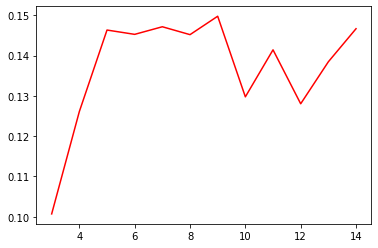

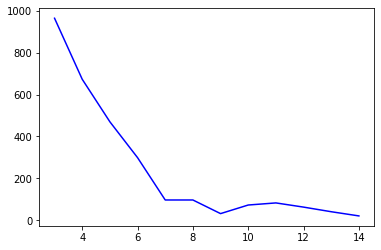

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

matrix = X.values
Silhouettes = []
MinClusterSizes = []
N=[]
for n_clusters in range(3,15):
    N.append(n_clusters)
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    Silhouettes.append(silhouette_avg)

    labels_hist = {}
    #kmeans.labels_ = [1,2,1...]
    for l in kmeans.labels_:
      if l not in labels_hist:
        labels_hist[l] = 0
      labels_hist[l] += 1
    
    MinClusterSizes.append(np.min(list(labels_hist.values())))
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

plt.plot(N, Silhouettes, c='r')
plt.show()
plt.plot(N, MinClusterSizes, c='b')
plt.show()
n_clusters = 5

The scores obtained above can be considered equivalent since, depending on the run, scores of 0.1±0.05 will be obtained for all clusters with n_clusters > 3. On the other hand, beyond 5 clusters, some clusters contained very few elements. We therefore choose to separate the dataset into 5 clusters.

## 3.9) Adjust the model
K-means can converge to local minimum, and sometimes it is usefull to run it several times to get better silhouette score. Choose threshold equal to 0.145 (or more) and achieve score better than this number. Investigate nuber of elements in clusters.

In [65]:
silhouette_avg = -1
n_clusters = 5
while silhouette_avg < 0.147:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

pd.Series(clusters).value_counts()

For n_clusters = 5 The average silhouette_score is : 0.1470081849157512


3    1009
1     964
4     673
0     626
2     606
dtype: int64

In [66]:
features = X.keys()
for center in kmeans.cluster_centers_:
   features_dict = {features[i]:center[i] for i in range(len(features))}
   sorted_features = sorted(features_dict.items(), key =lambda kv:(-kv[1], kv[0]))
   sorted_features = [f[0] for f in sorted_features]
   print(sorted_features[:7])

['5<.<10', '.>10', 'art', 'lace', 'necklac', 'wall', 'glass']
['0<.<1', 'art', 'card', 'christmas', 'heart', 'wrap', 'set']
['3<.<5', 'art', 'set', 'heart', 'pot', 'vintage', 'glass']
['1<.<2', 'art', 'set', 'heart', 'sign', 'vintage', 'bag']
['2<.<3', 'art', 'bag', 'set', 'sign', 'pot', 'box']


## 3.10) Save data
Save variables `Matrix_X.csv` and `clusters` to your google drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
path = '/content/mydriv/My Drive/Customer_Segmentation/'
X.to_csv(path+"Matrix_X.csv")
(pd.Series(clusters)).to_csv(path + 'Matrix_X_clusters.csv', header = 'False')

# 4) Customer categories

In [0]:
# import pandas as pd
# import numpy as np

# from google.colab import drive
# drive.mount('/content/drive')
path = '/content/mydriv/My Drive/Customer_Segmentation/'
df_cleaned = pd.read_csv(path + 'data_cleaned.csv', encoding='latin', dtype={'CustomerID': str}) 
X = pd.read_csv(path + 'Matrix_X.csv') 

unique_products = df_cleaned['Description'].unique()
clusters_tmp = pd.read_csv(path + 'Matrix_X_clusters.csv') 
clusters = clusters_tmp.to_numpy()[:,1]

## 4.1) New feature

Add new feature: `categ_product` into `df_cleaned` dataframe. Use information, obtained in previous part: `clusters` and `unique_procudts`.

Use `map` and `zip` if you want.

In [69]:
print(unique_products.shape)
print(clusters.shape)
corresp = dict()
for key, val in zip(unique_products, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned.head(5)

(3878,)
(3878,)


,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCancel,TotalPrice,categ_product
0,0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1
1,1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3
2,2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,3
3,3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3
4,4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,3


## 4.2) Money spent for categories
Add 5 new features with names `categ_0` to `categ_4` to `df_cleaned` dataset, which indicate the money spent on each product category.

In [70]:
# add 5 variables - the money spent on each of the 5 categories
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['TotalPrice']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.0,0.00,0.0
1,536365,WHITE METAL LANTERN,3,0.0,0.0,0.0,20.34,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,3,0.0,0.0,0.0,22.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3,0.0,0.0,0.0,20.34,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.0,0.0,20.34,0.0


## 4.3) Aggregate price with categories

We then create a dataframe where each row is a purchase (unique `InvoiceNo`) with total amount of money, and the amount spent on each product category.
Read and understand the following code.

The features we have here are the following:
`CustomerID`, `InvoiceNo`, `Basket Price`, `categ_0` to `categ_4` and `InvoiceDate`


In [71]:
# sum the commands for each order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
Aggregate_Price = temp.rename(columns = {'TotalPrice':'agg_price'})
Aggregate_Price.head()

,CustomerID,InvoiceNo,agg_price
0,12346,541431,0.00
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52


In [75]:
# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    Aggregate_Price.loc[:, col] = temp

Aggregate_Price.head() 

,CustomerID,InvoiceNo,agg_price,categ_0,categ_1,categ_2,categ_3,categ_4
1,12347,537626,711.79,124.44,83.40,23.40,293.35,187.2
2,12347,542237,475.39,38.25,53.10,84.34,169.20,130.5
3,12347,549222,636.25,38.25,71.10,81.00,115.00,330.9
4,12347,556201,382.52,19.90,78.06,41.40,168.76,74.4
5,12347,562032,584.91,136.05,119.70,61.30,158.16,109.7


In [76]:
# keep only positive purchases
Aggregate_Price = Aggregate_Price[Aggregate_Price['agg_price'] > 0]
Aggregate_Price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,agg_price,categ_0,categ_1,categ_2,categ_3,categ_4
1,12347,537626,711.79,124.44,83.40,23.40,293.35,187.2
2,12347,542237,475.39,38.25,53.10,84.34,169.20,130.5
3,12347,549222,636.25,38.25,71.10,81.00,115.00,330.9
4,12347,556201,382.52,19.90,78.06,41.40,168.76,74.4
5,12347,562032,584.91,136.05,119.70,61.30,158.16,109.7


In [77]:
len(Aggregate_Price) #check

18398

## 4.4) Customer data

We create a dataframe where each row correspond to a customer. The columns are CustomerID, number of transactions, min, max, mean, sum of spent money, and percentage of money for each category.
Call this new dataframe `transactions_per_user`.

In [78]:
transactions_per_user = Aggregate_Price.groupby(by=['CustomerID'])['agg_price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = Aggregate_Price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
Aggregate_Price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,12.041531,20.805104,11.237123,29.540371,26.375870
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,0.000000,38.016069,0.000000,41.953217
2,12349,1,1757.55,1757.55,1757.550000,1757.55,46.021450,12.245455,4.513101,10.713778,26.506216
3,12350,1,334.40,334.40,334.400000,334.40,11.961722,27.900718,11.692584,0.000000,48.444976
4,12352,7,144.35,840.30,340.815714,2385.71,64.322571,4.071325,1.299404,14.601523,15.705178


In [79]:
# Customers purchase only once
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("number of clients with only one purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

number of clients with only one purchase: 1489/4327  (34.41%)


## 4.5) Creation of customers categories
Choose features: `count`,`min`,`max`,`mean`,`categ_0`,`categ_1`,`categ_2`,`categ_3`,`categ_4` and create new matrix `matrix_customers`. Use standard scaler and call the result as `scaled_matrix_customers`.

In [80]:
# Use the features below
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix_customers = selected_customers[list_cols].values 
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,12.041531,20.805104,11.237123,29.540371,26.375870
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,0.000000,38.016069,0.000000,41.953217
2,12349,1,1757.55,1757.55,1757.550000,1757.55,46.021450,12.245455,4.513101,10.713778,26.506216
3,12350,1,334.40,334.40,334.400000,334.40,11.961722,27.900718,11.692584,0.000000,48.444976
4,12352,7,144.35,840.30,340.815714,2385.71,64.322571,4.071325,1.299404,14.601523,15.705178


In [81]:
# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix_customers)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)

scaled_matrix_customers = scaler.transform(matrix_customers)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.25190663 241.38253571 578.87676959 372.25705475  22.00477215
  21.62911535  14.09365548  16.97264402  25.30761412]


## 4.6) K-Means again - for customers
**Task:** Apply KMeans to scaled_matrix with numbers of clusters from 3 to 14 included. Compute the silhouetter score for each number. Print number of clients in each category.

In [82]:
# Try some numbers of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix_customers)
    clusters = kmeans.predict(scaled_matrix_customers)
    #print(pd.DataFrame(pd.Series(clusters).value_counts(), columns = ['nb. of clients']).T)
    silhouette_avg = silhouette_score(scaled_matrix_customers, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.15829281270198933
For n_clusters = 4 The average silhouette_score is : 0.15373360324357085
For n_clusters = 5 The average silhouette_score is : 0.1663291835789565
For n_clusters = 6 The average silhouette_score is : 0.1701044260370565
For n_clusters = 7 The average silhouette_score is : 0.18497551812944155
For n_clusters = 8 The average silhouette_score is : 0.20234803957441075
For n_clusters = 9 The average silhouette_score is : 0.2143735862831922
For n_clusters = 10 The average silhouette_score is : 0.21345322066587244
For n_clusters = 11 The average silhouette_score is : 0.22229163943060226
For n_clusters = 12 The average silhouette_score is : 0.18476167716700728
For n_clusters = 13 The average silhouette_score is : 0.18581662554963263
For n_clusters = 14 The average silhouette_score is : 0.1875464237235567


Based on the silhouette score we use 11 clusters

In [123]:
# 11 clusters
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix_customers)
clusters_clients = kmeans.predict(scaled_matrix_customers)
silhouette_avg = silhouette_score(scaled_matrix_customers, clusters_clients)
print('score of silhouette: {:<.3f}'.format(silhouette_avg))

score of silhouette: 0.223


In [84]:
# nb of customers per cluster
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. of clients']).T

,0,7,3,5,9,8,2,4,1,6,10
nb. of clients,1865,571,527,327,306,305,204,186,17,12,7


## 4.7) Customers morphotype

In this section, we compute the statistics for each group of customers and visulize them. Create new `merged_df` dataset with the same features as `transactions_per_user` dataframe, but with `n_clusters` rows: for each cluster - use mean of values. So you should have dataframe with sizes `n_cluster` $\times$ 12.

In [85]:
# Customer clusters
selected_customers.loc[:, 'cluster'] = clusters_clients

merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

merged_df

number of customers: 4327


,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
cluster,,,,,,,,,,,
5.0,2.366972,185.007798,317.093578,240.877856,608.378960,7.917795,12.043538,52.632638,6.902142,20.505084,327
7.0,2.702277,203.835657,342.689054,268.132903,747.747918,8.944049,14.118102,12.912598,8.489702,55.548474,571
3.0,2.844402,201.808161,356.907021,267.921020,787.949034,62.162394,10.709688,4.818099,11.245375,11.075151,527
8.0,2.632787,193.050623,353.469475,264.087535,857.597016,13.611200,13.023190,6.836176,53.708035,12.846950,305
9.0,2.993464,196.866111,400.625294,292.546668,968.485915,8.861939,63.514815,6.801407,7.306501,13.515338,306
0.0,3.656300,207.503432,488.843084,334.138772,1246.321116,20.471057,22.842061,13.216055,18.342074,25.134225,1865
4.0,2.016129,1022.101774,1492.718177,1247.068148,2697.974038,22.735350,20.899456,11.530385,18.915880,25.919292,186
6.0,1.500000,4075.741667,6245.503333,5073.737778,7931.028333,22.856542,24.582946,19.206717,15.135140,18.218655,12
2.0,20.745098,71.372255,1339.072794,478.024270,9745.359559,22.833328,24.958885,11.877181,17.008914,23.332127,204


## 4.8) Save data
Save selected_customers data to the file `data_selected_customers.csv`

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
path = '/content/mydriv/My Drive/Customer_Segmentation/'
selected_customers.to_csv(path + 'data_selected_customers.csv')

# 5) Classification of customers

In this section we try to classify customers to the above clusters using some features 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4'. Thus, we can use our models to classify a customer at the first purchase.


In [91]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')
path = '/content/mydriv/My Drive/Customer_Segmentation/'
selected_customers = pd.read_csv(path + 'data_selected_customers.csv')
import warnings
warnings.filterwarnings('ignore') 
print(selected_customers.shape)

(4327, 13)


In [90]:
selected_customers.head()


,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,cluster
0,0,12347,7,224.82,1294.32,615.714286,4310.00,12.041531,20.805104,11.237123,29.540371,26.375870,9
1,1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,0.000000,38.016069,0.000000,41.953217,6
2,2,12349,1,1757.55,1757.55,1757.550000,1757.55,46.021450,12.245455,4.513101,10.713778,26.506216,1
3,3,12350,1,334.40,334.40,334.400000,334.40,11.961722,27.900718,11.692584,0.000000,48.444976,5
4,4,12352,7,144.35,840.30,340.815714,2385.71,64.322571,4.071325,1.299404,14.601523,15.705178,10


We first build a class `Class_Fit` to manage classifier.

In [0]:
class Class_Fit:
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Accuracy: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## 5.1) Prepare train and validation data 

In [0]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

In [109]:
Y_train.head()

1876     9
2716     9
3301    10
279     10
3905     2
Name: cluster, dtype: int64

In [110]:
X_train.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
1876,316.210000,7.016698,40.226432,18.815819,9.499225,24.441827
2716,242.193333,19.275235,24.350381,6.077101,24.088882,26.208401
3301,72.455000,63.349665,7.245877,7.701332,21.703126,0.000000
279,434.835000,44.608875,6.289742,22.091138,6.002277,21.007969
3905,451.967500,1.349655,66.487635,9.511746,3.938336,18.712629


## 5.2) SVM classifier

Here I build an SVM classifier. Use GridSearchCV with logarithmic scale from 0.01 to 100. For Cross-Validation use 5 folds.

In [0]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
svc = Class_Fit(clf = svm.LinearSVC, params={'max_iter':100})
svc.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
# to do - fix number of iterations

In [0]:
from sklearn import metrics
svc.grid_fit(X = X_train, Y = Y_train)
#output is too big, try to supress it

In [114]:
 svc.grid_predict(X_test, Y_test)

Accuracy: 50.58 % 


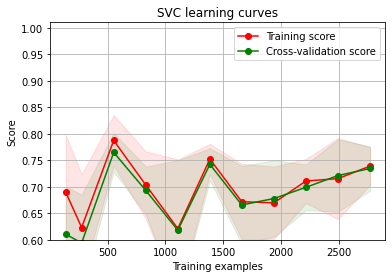

In [115]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

# plot learning curves
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [0.6, 1.01],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])


## 5.3) Logistic regression

**Task:** Similarly, build a logistic regression using `Class_Fit`, use grid search to train. Then compute the test precision and plot learning curves.

In [0]:
from sklearn.linear_model import LogisticRegression
lr = Class_Fit(clf = LogisticRegression, params={'solver':'lbfgs', 'multi_class':'auto', 'max_iter':300})
lr.grid_search(parameters={'C':np.logspace(-2,2,10)}, Kfold=5)

In [0]:
lr.grid_fit(X_train, Y_train)

In [118]:
lr.grid_predict(X_test, Y_test)

Accuracy: 90.99 % 


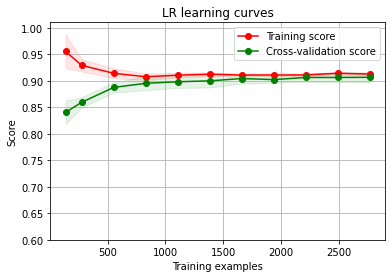

In [119]:
g2 = plot_learning_curve(lr.grid.best_estimator_,
                        "LR learning curves", X_train, Y_train, ylim = [0.6, 1.01],
                         cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                 0.6, 0.7, 0.8, 0.9, 1])

## 5.4) k-nearest neighbors

**Task:** Build a knn using `Class_Fit`, use grid search to train. Then compute the test precision and plot learning curves.


In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = Class_Fit(clf = KNeighborsClassifier, params=None)
knn.grid_search(parameters={'n_neighbors':np.concatenate((np.arange(1,10,1),
                                                          np.arange(10,40,5),
                                                          np.arange(40,80,10)))},
                Kfold=5)
knn.grid_fit(X_train, Y_train)

In [121]:
knn.grid_predict(X_test, Y_test)

Accuracy: 81.64 % 


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

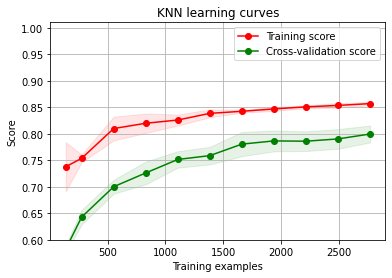

In [122]:
plot_learning_curve(knn.grid.best_estimator_, 'KNN learning curves', X_train, Y_train, ylim=[0.6, 1.01],
                   train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.5) Decision tree

**Task:** Build a decision tree using `Class_Fit`, use grid search to train. Then compute the test precision and plot learning curves.

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = Class_Fit(clf=DecisionTreeClassifier, params=None)
dt.grid_search(parameters={'min_samples_leaf':np.concatenate((np.arange(1,5,1),
                                                              np.arange(5,25,5),
                                                              np.arange(25,55,10),
                                                              np.arange(55,200,20)))},
               Kfold=5)
dt.grid_fit(X_train, Y_train)

In [124]:
print(dt.grid.best_params_)
print(dt.grid_predict(X_test, Y_test))

{'min_samples_leaf': 15}
Accuracy: 87.30 % 
None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

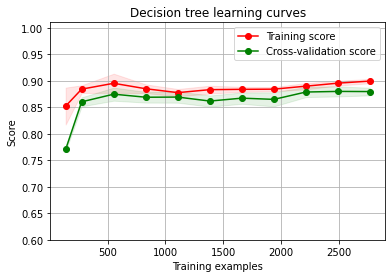

In [125]:
plot_learning_curve(dt.grid.best_estimator_, 'Decision tree learning curves', X_train, Y_train, ylim=[0.6, 1.01],
                   train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.6) Random forest

**Task:** Build a random forest using `Class_Fit`, use grid search to train. Then compute the test precision and plot learning curves.

In [127]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

rf = Class_Fit(clf=RandomForestClassifier, params=None)
rf.grid_search(parameters={'n_estimators':[100, 200],
                            'max_leaf_nodes':np.arange(5,20,2)},
                Kfold=5)
rf.grid_fit(X_train, Y_train)

rf.grid.best_params_, 

({'max_leaf_nodes': 19, 'n_estimators': 100},)

In [128]:
print(rf.grid_predict(X_test, Y_test))

Accuracy: 88.45 % 
None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

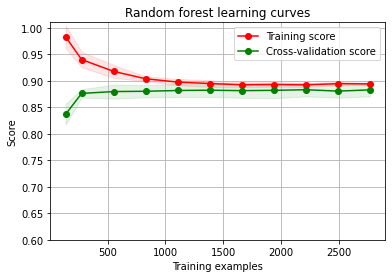

In [129]:
plot_learning_curve(rf.grid.best_estimator_, 'Random forest learning curves', X_train, Y_train, ylim=[0.6, 1.01],
                   train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.7) Adaboost

### Boosting

Boosting technique was originally designed for classificaiton. The idea is to have a procedure that combines the outputs of many "weak" classifiers to produce a powerful "committee".

### AdaBoost (Adaptive boosting)



In [130]:
from sklearn.ensemble import AdaBoostClassifier

ada = Class_Fit(clf=AdaBoostClassifier, params=None)

para_grid = {'base_estimator':[DecisionTreeClassifier(max_depth=1),
                               DecisionTreeClassifier(max_depth=5),
                               DecisionTreeClassifier(max_depth=7),
                               DecisionTreeClassifier(max_depth=9)
                              ],
             'algorithm':['SAMME','SAMME.R'],
             'n_estimators':[200] 
            }
ada.grid_search(parameters=para_grid, Kfold=5)

ada.grid_fit(X_train, Y_train)

ada.grid.best_params_, 

Accuracy: 89.84 % 


({'algorithm': 'SAMME.R',
  'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=9, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best'),
  'n_estimators': 200},
 None)

In [131]:
print(ada.grid_predict(X_test, Y_test))

Accuracy: 89.84 % 
None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

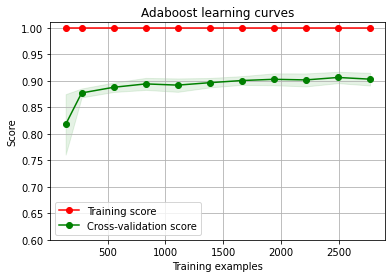

In [132]:
plot_learning_curve(ada.grid.best_estimator_, 'Adaboost learning curves', X_train, Y_train, ylim=[0.6, 1.01],
                   train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.8) Gradient boosting classifier

In gradient boosting we use a differentiable loss function $L(y, f(x))$, not exponential loss like AdaBoost. We might say that Gradient boosting is more general.



* Built a gradient boosting model using `Class_Fit`, use grid search to train. Then compute the test precision and plot learning curves.

In [133]:
from sklearn.ensemble import GradientBoostingClassifier 
gb = Class_Fit(clf=GradientBoostingClassifier, params=None)

para_grid = {
    'n_estimators':[100, 200, 300]
            }
gb.grid_search(parameters=para_grid, Kfold=5)

gb.grid_fit(X_train, Y_train)

gb.grid.best_params_, 


({'n_estimators': 100},)

In [134]:
print(ada.grid_predict(X_test, Y_test))

Accuracy: 89.84 % 
None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

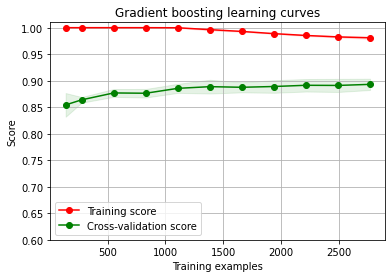

In [135]:
plot_learning_curve(gb.grid.best_estimator_, 'Gradient boosting learning curves', X_train, Y_train, ylim=[0.6, 1.01],
                   train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## 5.9) XGBoost 

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.

https://xgboost.readthedocs.io/en/latest/

In [136]:
from xgboost import XGBClassifier
xgb = Class_Fit(clf=XGBClassifier, params=None)

para_grid = {
    'objective':['multi:softmax'],
    'n_estimators':[100, 200, 300]
            }
xgb.grid_search(parameters=para_grid, Kfold=5)

xgb.grid_fit(X_train, Y_train)

xgb.grid.best_params_, 

({'n_estimators': 200, 'objective': 'multi:softmax'},)

In [137]:
print(ada.grid_predict(X_test, Y_test))

Accuracy: 89.84 % 
None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

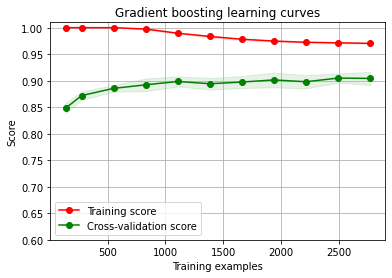

In [138]:
plot_learning_curve(xgb.grid.best_estimator_, 'Gradient boosting learning curves', X_train, Y_train, ylim=[0.6, 1.01],
                   train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# 5.10) Testing predictions

**Task:** For each trained model above, compute the precision on the test set.

**Task:** For each trained model above, compute the precision on the test set.

In [139]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logistic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (dt, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting'),
                (xgb, 'XGBoost')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X_test, Y_test)

______________________________ 
Support Vector Machine
Accuracy: 50.58 % 
______________________________ 
Logistic Regression
Accuracy: 90.99 % 
______________________________ 
k-Nearest Neighbors
Accuracy: 81.64 % 
______________________________ 
Decision Tree
Accuracy: 87.30 % 
______________________________ 
Random Forest
Accuracy: 88.45 % 
______________________________ 
Gradient Boosting
Accuracy: 89.72 % 
______________________________ 
XGBoost
Accuracy: 91.34 % 
